# Scraper for a fighters' specific data

## Imports for scraping data from a website

In [9]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os

## Screenshot of table one
![Statistics table one](Images/statistics_table_one.png)

## Screenshot of table two
![Statistics table two](Images/statistics_table_two.png)

## Method for scraping fighter specific data

In [10]:
def scrape_fighter_URL(fighter_url):
    try:
        response = requests.get(fighter_url)

        soup = BeautifulSoup(response.content, 'html.parser')

        #Try finding the stats table using the BeautifulSoup, pass the name of the div of the DOM
        stats_table_one = soup.find('div', class_='b-list__info-box-left clearfix')
        
        #Since there are two tables that contain the fighter statistics I need to scrape both the divs
        stats_table_two = soup.find('div', class_='b-list__info-box-right b-list__info-box_style-margin-right')
        
        # A variable to store the data
        statistics = {}
        
        if stats_table_one:
            # Thats the div that contains the stats
            stats_list_one = stats_table_one.find('ul', class_='b-list__box-list b-list__box-list_margin-top')
            # If a the div with the stats is found we iterate through each entry and store it in the statistics datastructure
            if stats_list_one:
                for item in stats_list_one.find_all('li', class_='b-list__box-list-item b-list__box-list-item_type_block'):
                    # Extract the text from the list item
                    stat_text_one = item.get_text(strip=True)
                    # print(stat_text_one)
                    if ':' in stat_text_one:
                        key, value = [s.strip() for s in stat_text_one.split(':', 1)]
                        statistics[key] = value
        if stats_table_two:
            stats_list_two = stats_table_two.find('ul', class_='b-list__box-list b-list__box-list_margin-top')
            if stats_list_two:
                for item in stats_list_two.find_all('li', class_='b-list__box-list-item b-list__box-list-item_type_block'):
                    stat_text_two = item.get_text(strip=True)
                    # print(stat_text_two)
                    if ':' in stat_text_two:
                        key, value = [s.strip() for s in stat_text_two.split(':', 1)]
                        statistics[key] = value
                    
            return statistics if statistics else None
        else:
            print("Statistics section not found.")
            return None

    except requests.exceptions.RequestException as e:
        print(f"Error fetching the fighter's page: {e}")
        return None

# # Example usage
fighter_url = "http://ufcstats.com/fighter-details/15df64c02b6b0fde"  # Replace with the actual fighter URL
fighter_statistics = scrape_fighter_URL(fighter_url)
print(fighter_statistics)

{'SLpM': '3.29', 'Str. Acc.': '38%', 'SApM': '4.41', 'Str. Def': '57%', 'TD Avg.': '0.00', 'TD Acc.': '0%', 'TD Def.': '77%', 'Sub. Avg.': '0.0'}


# Scrapper for UFC data

### Code for scraping the UFC statistics website

In [11]:
URL = "http://ufcstats.com/statistics/fighters?char=d&page=all"
page = requests.get(URL)

soup = BeautifulSoup(page.content, "html.parser")

table = soup.find('table', class_='b-statistics__table')

data = []
data_specific_fighter = []

for row in table.find_all('tr', class_='b-statistics__table-row'):
    cells = row.find_all('td')
    cell_value = [cell.get_text(strip=True) for cell in cells]
    
    data.append(cell_value)

    fighter_link = row.select_one('td a')
    
    if fighter_link and fighter_link.has_attr('href'):
        fighter_url = fighter_link.get('href')
        
        #this already should store the specific data for the fighter
        data_specific_fighter = scrape_fighter_URL(fighter_url)
        
        data.append(data_specific_fighter)
        
        df= pd.DataFrame(data)
        
        df.to_excel('test.xlsx', index=False)
        

In [12]:
URL = "http://ufcstats.com/statistics/fighters?char=z&page=all"
page = requests.get(URL)
soup = BeautifulSoup(page.content, "html.parser")

table = soup.find('table', class_='b-statistics__table')

# List to store combined data for all fighters
all_fighters_data = []

# Iterate through each row of the table to collect data
for row in table.find_all('tr', class_='b-statistics__table-row'):
    cells = row.find_all('td')

    # Extract the general information from the main page
    if len(cells) >= 8:
        # Split the name into first and last (assuming first and last name)
        first_name = cells[0].get_text(strip=True)
        last_name = cells[1].getText(strip=True)
        nickname = cells[2].getText(strip=True)
        height = cells[3].getText(strip=True)
        weight = cells[4].getText(strip=True)
        reach = cells[5].getText(strip=True)
        stance = cells[6].getText(strip=True)
        wins = cells[7].getText(strip=True)
        losses = cells[8].getText(strip=True)
        draws = cells[9].getText(strip=True)

        # Create a list to store all data in a single row
        fighter_data = [
            first_name,
            last_name,
            nickname,
            height,
            weight,
            reach,
            stance,
            wins,
            losses,
            draws
        ]

        # Find the fighter's profile link and scrape specific fighter data
        fighter_link = cells[0].find('a')
        if fighter_link and fighter_link.has_attr('href'):
            fighter_url = fighter_link['href']
            specific_fighter_data = scrape_fighter_URL(fighter_url)

            # Extract specific stats and append to fighter data
            specific_stats = [
                specific_fighter_data.get('SLpM', None),
                specific_fighter_data.get('Str. Acc.', None),
                specific_fighter_data.get('SApM', None),
                specific_fighter_data.get('Str. Def', None),
                specific_fighter_data.get('TD Avg.', None),
                specific_fighter_data.get('TD Def.', None),
                specific_fighter_data.get('Sub. Avg.', None)
            ]
            fighter_data.extend(specific_stats)

        # Append the complete data for the fighter as a single row
        all_fighters_data.append(fighter_data)

# Define column names
column_names = [
    "First Name", "Last Name", "Nickname", "Height", "Weight", "Reach", "Stance", "W", "L", "D",
    "SLpM", "Str. Acc.", "SApM", "Str. Def", "TD Avg.", "TD Def.", "Sub. Avg."
]

# Create a DataFrame from the combined data
df = pd.DataFrame(all_fighters_data, columns=column_names)

# Save the DataFrame to an Excel file
# df.to_excel('all_fighters(Z).xlsx', index=False)

# Print the first few rows to verify
print(df.head())

  First Name Last Name            Nickname  Height    Weight  Reach    Stance  \
0       Luke  Zachrich                       6' 2"  185 lbs.  74.0"  Orthodox   
1      Anton     Zafir       The Professor  5' 11"  170 lbs.     --  Orthodox   
2    Aiemann    Zahabi                       5' 8"  135 lbs.  68.0"  Orthodox   
3       Joao    Zaiden                          --  205 lbs.     --             
4    Youssef     Zalal  The Moroccan Devil  5' 10"  145 lbs.  72.0"    Switch   

    W  L  D  SLpM Str. Acc.  SApM Str. Def TD Avg. TD Def. Sub. Avg.  
0  14  4  0  4.56       32%  4.46      62%    0.74     80%       0.0  
1   7  3  0  2.99       64%  2.31      52%    6.11      0%       0.0  
2  12  2  0  4.06       46%  4.06      71%    0.16     83%       0.0  
3  10  3  0  0.00        0%  0.00       0%    0.00      0%       0.0  
4  16  5  1  2.84       49%  1.71      65%    2.34     59%       1.5  


### Combining the files

In [13]:
# dfs = []
# 
# # folder = "Statistics"
# 
# path = os.path.join(os.getcwd(), folder)
# 
# files = sorted(os.listdir(path))
# 
# for file in files:
#     if file.endswith(".xlsx"):
#         file_path = os.path.join(path, file)
#         
#         df = pd.read_excel(file_path)
#         
#         dfs.append(df)
#         
#         print(f"Successfully read file: {file_path}")
#         
# if dfs:
#     combined_df = pd.concat(dfs, ignore_index=True)
#     combined_df.to_excel('Combined_UFC_Fighter_Statistics.xlsx', index=False)
#     print("Files combined and saved!")
# 
# combined_df.head()

# UFC prediction model

## Imports

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## Normalizing

In [15]:
combined_df = pd.read_excel('Combined_UFC_Fighter_Statistics.xlsx')

combined_df.head()

First Name   Last Name      Nickname  Height    Weight  Reach    Stance   W  \
0        Tom       Aaron           NaN      --  155 lbs.     --       NaN   5   
1      Danny      Abbadi  The Assassin  5' 11"  155 lbs.     --  Orthodox   4   
2    Nariman     Abbasov     Bayraktar   5' 8"  155 lbs.  66.0"  Orthodox  28   
3      David      Abbott          Tank   6' 0"  265 lbs.     --    Switch  10   
4      Hamdy  Abdelwahab    The Hammer   6' 2"  264 lbs.  72.0"  Southpaw   5   

    L  D  SLpM Str. Acc.  SApM Str. Def  TD Avg. TD Def.  Sub. Avg.  
0   3  0  0.00        0%  0.00       0%     0.00      0%        0.0  
1   6  0  3.29       38%  4.41      57%     0.00     77%        0.0  
2   4  0  3.00       20%  5.67      46%     0.00     66%        0.0  
3  15  0  1.35       30%  3.55      38%     1.07     66%        0.0  
4   0  0  3.87       52%  3.13      59%     3.00      0%        0.0

### Converting 'Height' and 'Reach' to centimeteres

I have converted the 'Height' and 'Reach' features which were in inches to centimeters and rounded them to 0 for better readability

In [16]:
import numpy as np

# Convert heights from feet and inches to inches
def height_to_inches(height):
    if pd.isnull(height) or height == '--':
        return np.nan
    try:
        feet, inches = height.split("'")
        inches = int(feet) * 12 + int(inches.strip('"'))
        return inches
    except:
        return np.nan

# Apply the height conversion function
combined_df['Height'] = combined_df['Height'].apply(height_to_inches)

# Clean the Reach column by stripping the quotation marks and converting to float
combined_df['Reach'] = combined_df['Reach'].str.rstrip('"').replace('--', np.nan).astype(float)

# Fill missing height and reach values with the mean of the respective columns and round them to 0
combined_df['Height'].fillna(combined_df['Height'].mean(), inplace=True)
combined_df['Reach'].fillna(combined_df['Reach'].mean(), inplace=True)

# Round the Height and Reach columns to the nearest integer
combined_df['Height'] = combined_df['Height'].round(0)
combined_df['Reach'] = combined_df['Reach'].round(0)

# Display the updated DataFrame
combined_df.head()


/var/folders/kc/28jr57sx1vq8g59l2w0x2jhh0000gn/T/ipykernel_98786/2992620531.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['Height'].fillna(combined_df['Height'].mean(), inplace=True)
/var/folders/kc/28jr57sx1vq8g59l2w0x2jhh0000gn/T/ipykernel_98786/2992620531.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which 

First Name   Last Name      Nickname  Height    Weight  Reach    Stance   W  \
0        Tom       Aaron           NaN    70.0  155 lbs.   72.0       NaN   5   
1      Danny      Abbadi  The Assassin    71.0  155 lbs.   72.0  Orthodox   4   
2    Nariman     Abbasov     Bayraktar    68.0  155 lbs.   66.0  Orthodox  28   
3      David      Abbott          Tank    72.0  265 lbs.   72.0    Switch  10   
4      Hamdy  Abdelwahab    The Hammer    74.0  264 lbs.   72.0  Southpaw   5   

    L  D  SLpM Str. Acc.  SApM Str. Def  TD Avg. TD Def.  Sub. Avg.  
0   3  0  0.00        0%  0.00       0%     0.00      0%        0.0  
1   6  0  3.29       38%  4.41      57%     0.00     77%        0.0  
2   4  0  3.00       20%  5.67      46%     0.00     66%        0.0  
3  15  0  1.35       30%  3.55      38%     1.07     66%        0.0  
4   0  0  3.87       52%  3.13      59%     3.00      0%        0.0

### Stance conversion into 0, 1 or 2

In [17]:
combined_df['Stance'].fillna('Unknown', inplace=True)

stance_mapping = {'Switch' : 0, 'Orthodox': 1, 'Southpaw': 2}

combined_df['Stance'] = combined_df['Stance'].map(stance_mapping)

combined_df.to_excel('Updated_UFC_File.xlsx', index=False)

combined_df.head()

/var/folders/kc/28jr57sx1vq8g59l2w0x2jhh0000gn/T/ipykernel_98786/1291251314.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['Stance'].fillna('Unknown', inplace=True)


First Name   Last Name      Nickname  Height    Weight  Reach  Stance   W  \
0        Tom       Aaron           NaN    70.0  155 lbs.   72.0     NaN   5   
1      Danny      Abbadi  The Assassin    71.0  155 lbs.   72.0     1.0   4   
2    Nariman     Abbasov     Bayraktar    68.0  155 lbs.   66.0     1.0  28   
3      David      Abbott          Tank    72.0  265 lbs.   72.0     0.0  10   
4      Hamdy  Abdelwahab    The Hammer    74.0  264 lbs.   72.0     2.0   5   

    L  D  SLpM Str. Acc.  SApM Str. Def  TD Avg. TD Def.  Sub. Avg.  
0   3  0  0.00        0%  0.00       0%     0.00      0%        0.0  
1   6  0  3.29       38%  4.41      57%     0.00     77%        0.0  
2   4  0  3.00       20%  5.67      46%     0.00     66%        0.0  
3  15  0  1.35       30%  3.55      38%     1.07     66%        0.0  
4   0  0  3.87       52%  3.13      59%     3.00      0%        0.0

### Creating 'Total_Fights' and 'Win_Percentage' features for each fighter

In [18]:
combined_df['Total_Fights'] = combined_df['W'] + combined_df['L'] + combined_df['D']

combined_df['Win_Percentage'] = (combined_df['W'] / combined_df['Total_Fights']) * 100

# Fill NaN or infinite values with 0 before converting to integer
combined_df['Win_Percentage'] = combined_df['Win_Percentage'].fillna(0).replace([float('inf'), -float('inf')], 0).round(0).astype(int)

combined_df['Win_Percentage'] = combined_df['Win_Percentage'].astype(str) + '%'

#Grappler will be 0 and striker will be 1
combined_df['Grappler/Striker'] = combined_df['TD Avg.'].apply(lambda x: 0 if x > 1 else 1)

combined_df.to_excel('UFC_Statistics.xlsx', index=False)

# combined_df.head()

# Calculate the number of grapplers (0) and strikers (1)
grappler_count = combined_df[combined_df['Grappler/Striker'] == 0].shape[0]
striker_count = combined_df[combined_df['Grappler/Striker'] == 1].shape[0]

# Display the counts
print(f"Number of Grapplers: {grappler_count}")
print(f"Number of Strikers: {striker_count}")

Number of Grapplers: 1690
Number of Strikers: 2524


## Correlation matrisses

In [19]:
# Convert 'W', 'L', and 'D' to win percentage
combined_df['Total_Fights'] = combined_df['W'] + combined_df['L'] + combined_df['D']
combined_df['Win_Percentage'] = combined_df['W'] / combined_df['Total_Fights']

# Drop fighters with no fights (to avoid division by zero)
combined_df = combined_df[combined_df['Total_Fights'] > 0]

# Select relevant features for correlation
features = ['SLpM', 'Str. Acc.', 'SApM', 'Str. Def', 'TD Avg.', 'TD Def.', 'Sub. Avg.','Stance','Win_Percentage']

# Ensure the columns are strings before stripping '%' and converting to float
combined_df['Str. Acc.'] = combined_df['Str. Acc.'].astype(str).str.rstrip('%').astype(float)
combined_df['Str. Def'] = combined_df['Str. Def'].astype(str).str.rstrip('%').astype(float)
combined_df['TD Def.'] = combined_df['TD Def.'].astype(str).str.rstrip('%').astype(float)

# Calculate correlation
correlation_matrix = combined_df[features].corr()

# Display the correlation matrix
print(correlation_matrix)

                    SLpM  Str. Acc.      SApM  Str. Def   TD Avg.   TD Def.  \
SLpM            1.000000   0.634465  0.451202  0.542647  0.118233  0.484446   
Str. Acc.       0.634465   1.000000  0.295307  0.645899  0.300027  0.492627   
SApM            0.451202   0.295307  1.000000  0.268562 -0.030377  0.151370   
Str. Def        0.542647   0.645899  0.268562  1.000000  0.254082  0.524013   
TD Avg.         0.118233   0.300027 -0.030377  0.254082  1.000000  0.152699   
TD Def.         0.484446   0.492627  0.151370  0.524013  0.152699  1.000000   
Sub. Avg.      -0.012297   0.143740 -0.054679  0.136988  0.208753  0.018439   
Stance         -0.064757  -0.002072 -0.056696  0.024256  0.008774 -0.008806   
Win_Percentage  0.335753   0.346190  0.106782  0.292274  0.160902  0.267495   

                Sub. Avg.    Stance  Win_Percentage  
SLpM            -0.012297 -0.064757        0.335753  
Str. Acc.        0.143740 -0.002072        0.346190  
SApM            -0.054679 -0.056696        0.10

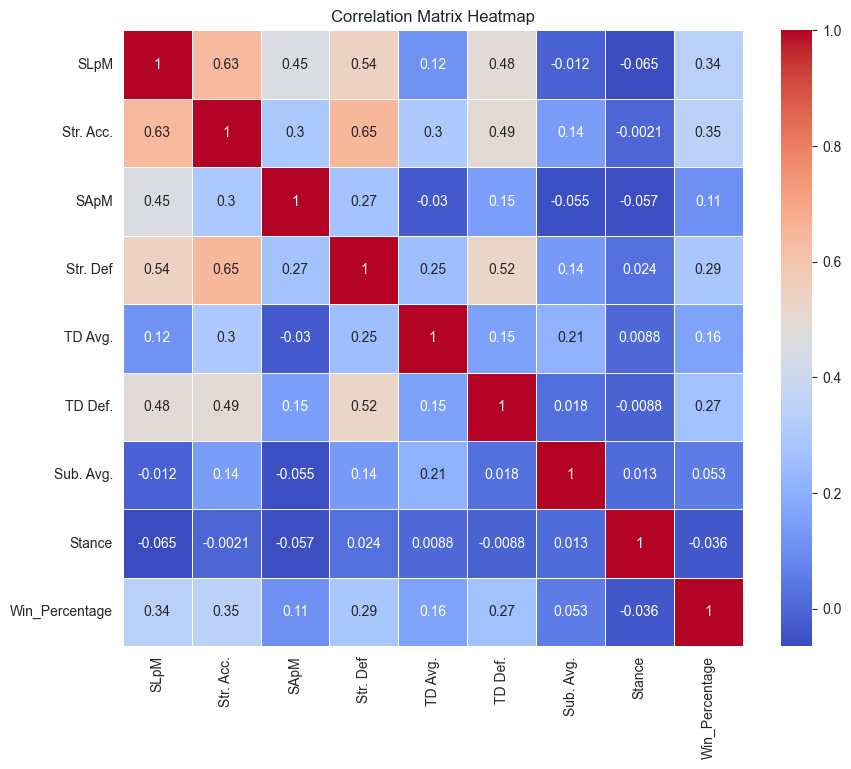

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

## Modelling the data

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Ensure the columns are strings before stripping '%' and converting to float
combined_df['Str. Acc.'] = combined_df['Str. Acc.'].astype(str).str.rstrip('%').astype(float) / 100.0
combined_df['Str. Def'] = combined_df['Str. Def'].astype(str).str.rstrip('%').astype(float) / 100.0
combined_df['Win_Percentage'] = combined_df['Win_Percentage'].astype(str).str.rstrip('%').astype(float) / 100.0
combined_df['TD Def.'] = combined_df['TD Def.'].astype(str).str.rstrip('%').astype(float) / 100.0

features = ['SLpM', 'Str. Acc.', 'SApM', 'Str. Def', 'TD Avg.', 'TD Def.', 'Sub. Avg.', 'Win_Percentage','Reach','Height','Grappler/Striker']
X = combined_df[features]

#Target variable
y = combined_df['W']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data (since features have different scales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy}")
print("Classification report:")
print(classification_report(y_test, y_pred))

Model accuracy: 0.1573301549463647
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.45      0.54      0.49        24
           2       0.05      0.06      0.06        17
           3       0.17      0.22      0.19        18
           4       0.33      0.40      0.36        20
           5       0.16      0.13      0.14        38
           6       0.11      0.17      0.13        41
           7       0.28      0.24      0.26        49
           8       0.11      0.14      0.12        51
           9       0.14      0.19      0.16        57
          10       0.06      0.08      0.07        37
          11       0.14      0.24      0.18        50
          12       0.07      0.10      0.08        41
          13       0.06      0.07      0.07        41
          14       0.09      0.07      0.08        43
          15       0.09      0.05      0.06        40
          16       0.00

/Users/danilburov/Desktop/Fontys/Semester5/MinorAI/PythonCR/Personal project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/danilburov/Desktop/Fontys/Semester5/MinorAI/PythonCR/Personal project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/danilburov/Desktop/Fontys/Semester5/MinorAI/PythonCR/Personal project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labe

### I realized that I do not have enough data to make the model more accurate, it is possible that I might change the approach where instead of training the model solely based on the fighters' data and when training the model I basically use only the fighter specific data to predict a fight.

### In order to make the model more accurate I will create or import a new dataset with more features. This dataset will have all fights from the beginning of the UFC, how they ended the fighters, etc.

# Data from Kaggle

In [72]:
ufc_data = pd.read_excel('data.xlsx')

ufc_data.head()

R_fighter          B_fighter        Referee       date  \
0   Adrian Yanez      Gustavo Lopez  Chris Tognoni 2021-03-20   
1   Trevin Giles      Roman Dolidze      Herb Dean 2021-03-20   
2    Tai Tuivasa    Harry Hunsucker      Herb Dean 2021-03-20   
3  Cheyanne Buys  Montserrat Conejo     Mark Smith 2021-03-20   
4  Marion Reneau      Macy Chiasson     Mark Smith 2021-03-20   

                 location Winner  title_bout       weight_class  B_avg_KD  \
0  Las Vegas, Nevada, USA    Red       False       Bantamweight     0.000   
1  Las Vegas, Nevada, USA    Red       False       Middleweight     0.500   
2  Las Vegas, Nevada, USA    Red       False        Heavyweight       NaN   
3  Las Vegas, Nevada, USA   Blue       False   WomenStrawweight       NaN   
4  Las Vegas, Nevada, USA   Blue       False  WomenBantamweight     0.125   

   B_avg_opp_KD  B_avg_SIG_STR_pct  B_avg_opp_SIG_STR_pct  B_avg_TD_pct  \
0           0.0           0.420000                0.49500         0.330   
1           0.0           0.660000                0.30500         0.300   
2           NaN                NaN                    NaN           NaN   
3           NaN                NaN                    NaN           NaN   
4           0.0           0.535625                0.57875         0.185   

   B_avg_opp_TD_pct  B_avg_SUB_ATT  B_avg_opp_SUB_ATT  B_avg_REV  \
0           0.36000          0.500             1.0000       0.00   
1           0.50000          1.500             0.0000       0.00   
2               NaN            NaN                NaN        NaN   
3               NaN            NaN                NaN        NaN   
4           0.16625          0.125             0.1875       0.25   

   B_avg_opp_REV  B_avg_SIG_STR_att  B_avg_SIG_STR_landed  \
0            0.0            50.0000               20.0000   
1            0.0            65.5000               35.0000   
2            NaN                NaN                   NaN   
3            NaN                NaN                   NaN   
4            0.0           109.1875               57.9375   

   B_avg_opp_SIG_STR_att  B_avg_opp_SIG_STR_landed  B_avg_TOTAL_STR_att  \
0                 84.000                   45.0000              76.5000   
1                 50.000                   16.5000             113.5000   
2                    NaN                       NaN                  NaN   
3                    NaN                       NaN                  NaN   
4                 50.625                   28.4375             170.4375   

   B_avg_TOTAL_STR_landed  B_avg_opp_TOTAL_STR_att  \
0                  41.000                  114.000   
1                  68.500                   68.500   
2                     NaN                      NaN   
3                     NaN                      NaN   
4                 105.625                   74.375   

   B_avg_opp_TOTAL_STR_landed  B_avg_TD_att  B_avg_TD_landed  \
0                       64.00         1.500              1.0   
1                       29.00         2.500              1.5   
2                         NaN           NaN              NaN   
3                         NaN           NaN              NaN   
4                       44.25         5.375              1.5   

   B_avg_opp_TD_att  B_avg_opp_TD_landed  B_avg_HEAD_att  B_avg_HEAD_landed  \
0               9.0                6.500          39.500             11.000   
1               0.5                0.500          46.000             20.000   
2               NaN                  NaN             NaN                NaN   
3               NaN                  NaN             NaN                NaN   
4               2.0                0.625          77.375             31.375   

   B_avg_opp_HEAD_att  B_avg_opp_HEAD_landed  B_avg_BODY_att  \
0             63.0000                 27.500          7.5000   
1             36.0000                  7.500         12.0000   
2                 NaN                    NaN             NaN   
3                 NaN             

In [73]:
## Printing all column names for analysis

pd.options.display.max_columns = None

column_names_ufc_data = ufc_data.columns

print(list(ufc_data.columns))

['R_fighter', 'B_fighter', 'Referee', 'date', 'location', 'Winner', 'title_bout', 'weight_class', 'B_avg_KD', 'B_avg_opp_KD', 'B_avg_SIG_STR_pct', 'B_avg_opp_SIG_STR_pct', 'B_avg_TD_pct', 'B_avg_opp_TD_pct', 'B_avg_SUB_ATT', 'B_avg_opp_SUB_ATT', 'B_avg_REV', 'B_avg_opp_REV', 'B_avg_SIG_STR_att', 'B_avg_SIG_STR_landed', 'B_avg_opp_SIG_STR_att', 'B_avg_opp_SIG_STR_landed', 'B_avg_TOTAL_STR_att', 'B_avg_TOTAL_STR_landed', 'B_avg_opp_TOTAL_STR_att', 'B_avg_opp_TOTAL_STR_landed', 'B_avg_TD_att', 'B_avg_TD_landed', 'B_avg_opp_TD_att', 'B_avg_opp_TD_landed', 'B_avg_HEAD_att', 'B_avg_HEAD_landed', 'B_avg_opp_HEAD_att', 'B_avg_opp_HEAD_landed', 'B_avg_BODY_att', 'B_avg_BODY_landed', 'B_avg_opp_BODY_att', 'B_avg_opp_BODY_landed', 'B_avg_LEG_att', 'B_avg_LEG_landed', 'B_avg_opp_LEG_att', 'B_avg_opp_LEG_landed', 'B_avg_DISTANCE_att', 'B_avg_DISTANCE_landed', 'B_avg_opp_DISTANCE_att', 'B_avg_opp_DISTANCE_landed', 'B_avg_CLINCH_att', 'B_avg_CLINCH_landed', 'B_avg_opp_CLINCH_att', 'B_avg_opp_CLINCH_l

In [74]:
data = pd.ExcelFile('data.xlsx')

sheet_data = data.parse(data.sheet_names[0])

horizontal_list = [f"{col} ({dtype})" for col, dtype in zip(sheet_data.columns, sheet_data.dtypes)]

horizontal_list

['R_fighter (object)',
 'B_fighter (object)',
 'Referee (object)',
 'date (datetime64[ns])',
 'location (object)',
 'Winner (object)',
 'title_bout (bool)',
 'weight_class (object)',
 'B_avg_KD (float64)',
 'B_avg_opp_KD (float64)',
 'B_avg_SIG_STR_pct (float64)',
 'B_avg_opp_SIG_STR_pct (float64)',
 'B_avg_TD_pct (float64)',
 'B_avg_opp_TD_pct (float64)',
 'B_avg_SUB_ATT (float64)',
 'B_avg_opp_SUB_ATT (float64)',
 'B_avg_REV (float64)',
 'B_avg_opp_REV (float64)',
 'B_avg_SIG_STR_att (float64)',
 'B_avg_SIG_STR_landed (float64)',
 'B_avg_opp_SIG_STR_att (float64)',
 'B_avg_opp_SIG_STR_landed (float64)',
 'B_avg_TOTAL_STR_att (float64)',
 'B_avg_TOTAL_STR_landed (float64)',
 'B_avg_opp_TOTAL_STR_att (float64)',
 'B_avg_opp_TOTAL_STR_landed (float64)',
 'B_avg_TD_att (float64)',
 'B_avg_TD_landed (float64)',
 'B_avg_opp_TD_att (float64)',
 'B_avg_opp_TD_landed (float64)',
 'B_avg_HEAD_att (float64)',
 'B_avg_HEAD_landed (float64)',
 'B_avg_opp_HEAD_att (float64)',
 'B_avg_opp_HEAD_land

In [33]:
ufc_data['R_Stance'].fillna('Unknown', inplace=True)

stance_mapping = {'Switch' : 0, 'Orthodox': 1, 'Southpaw': 2}

ufc_data['R_Stance'] = ufc_data['R_Stance'].map(stance_mapping)

# ufc_data.to_excel('Updated_UFC_File.xlsx', index=False)

ufc_data.head()

/var/folders/kc/28jr57sx1vq8g59l2w0x2jhh0000gn/T/ipykernel_98786/1489491440.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ufc_data['R_Stance'].fillna('Unknown', inplace=True)
/var/folders/kc/28jr57sx1vq8g59l2w0x2jhh0000gn/T/ipykernel_98786/1489491440.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  ufc_data['R_Stance'].fillna('Unknown', i

R_fighter          B_fighter        Referee       date  \
0   Adrian Yanez      Gustavo Lopez  Chris Tognoni 2021-03-20   
1   Trevin Giles      Roman Dolidze      Herb Dean 2021-03-20   
2    Tai Tuivasa    Harry Hunsucker      Herb Dean 2021-03-20   
3  Cheyanne Buys  Montserrat Conejo     Mark Smith 2021-03-20   
4  Marion Reneau      Macy Chiasson     Mark Smith 2021-03-20   

                 location Winner  title_bout       weight_class  B_avg_KD  \
0  Las Vegas, Nevada, USA    Red       False       Bantamweight     0.000   
1  Las Vegas, Nevada, USA    Red       False       Middleweight     0.500   
2  Las Vegas, Nevada, USA    Red       False        Heavyweight       NaN   
3  Las Vegas, Nevada, USA   Blue       False   WomenStrawweight       NaN   
4  Las Vegas, Nevada, USA   Blue       False  WomenBantamweight     0.125   

   B_avg_opp_KD  B_avg_SIG_STR_pct  B_avg_opp_SIG_STR_pct  B_avg_TD_pct  \
0           0.0           0.420000                0.49500         0.330   
1           0.0           0.660000                0.30500         0.300   
2           NaN                NaN                    NaN           NaN   
3           NaN                NaN                    NaN           NaN   
4           0.0           0.535625                0.57875         0.185   

   B_avg_opp_TD_pct  B_avg_SUB_ATT  B_avg_opp_SUB_ATT  B_avg_REV  \
0           0.36000          0.500             1.0000       0.00   
1           0.50000          1.500             0.0000       0.00   
2               NaN            NaN                NaN        NaN   
3               NaN            NaN                NaN        NaN   
4           0.16625          0.125             0.1875       0.25   

   B_avg_opp_REV  B_avg_SIG_STR_att  B_avg_SIG_STR_landed  \
0            0.0            50.0000               20.0000   
1            0.0            65.5000               35.0000   
2            NaN                NaN                   NaN   
3            NaN                NaN                   NaN   
4            0.0           109.1875               57.9375   

   B_avg_opp_SIG_STR_att  B_avg_opp_SIG_STR_landed  B_avg_TOTAL_STR_att  \
0                 84.000                   45.0000              76.5000   
1                 50.000                   16.5000             113.5000   
2                    NaN                       NaN                  NaN   
3                    NaN                       NaN                  NaN   
4                 50.625                   28.4375             170.4375   

   B_avg_TOTAL_STR_landed  B_avg_opp_TOTAL_STR_att  \
0                  41.000                  114.000   
1                  68.500                   68.500   
2                     NaN                      NaN   
3                     NaN                      NaN   
4                 105.625                   74.375   

   B_avg_opp_TOTAL_STR_landed  B_avg_TD_att  B_avg_TD_landed  \
0                       64.00         1.500              1.0   
1                       29.00         2.500              1.5   
2                         NaN           NaN              NaN   
3                         NaN           NaN              NaN   
4                       44.25         5.375              1.5   

   B_avg_opp_TD_att  B_avg_opp_TD_landed  B_avg_HEAD_att  B_avg_HEAD_landed  \
0               9.0                6.500          39.500             11.000   
1               0.5                0.500          46.000             20.000   
2               NaN                  NaN             NaN                NaN   
3               NaN                  NaN             NaN                NaN   
4               2.0                0.625          77.375             31.375   

   B_avg_opp_HEAD_att  B_avg_opp_HEAD_landed  B_avg_BODY_att  \
0             63.0000                 27.500          7.5000   
1             36.0000                  7.500         12.0000   
2                 NaN                    NaN             NaN   
3                 NaN             

In [54]:
stance_mapping = {'Switch' : 0, 'Orthodox': 1, 'Southpaw': 2}

ufc_data['B_Stance'] = ufc_data['B_Stance'].map(stance_mapping)
ufc_data['R_Stance'] = ufc_data['R_Stance'].map(stance_mapping)

ufc_data.to_excel('Updated_UFC_File.xlsx', index=False)

ufc_data.head()

R_fighter          B_fighter        Referee       date  \
0   Adrian Yanez      Gustavo Lopez  Chris Tognoni 2021-03-20   
1   Trevin Giles      Roman Dolidze      Herb Dean 2021-03-20   
2    Tai Tuivasa    Harry Hunsucker      Herb Dean 2021-03-20   
3  Cheyanne Buys  Montserrat Conejo     Mark Smith 2021-03-20   
4  Marion Reneau      Macy Chiasson     Mark Smith 2021-03-20   

                 location Winner  title_bout       weight_class  B_avg_KD  \
0  Las Vegas, Nevada, USA    Red       False       Bantamweight     0.000   
1  Las Vegas, Nevada, USA    Red       False       Middleweight     0.500   
2  Las Vegas, Nevada, USA    Red       False        Heavyweight       NaN   
3  Las Vegas, Nevada, USA   Blue       False   WomenStrawweight       NaN   
4  Las Vegas, Nevada, USA   Blue       False  WomenBantamweight     0.125   

   B_avg_opp_KD  B_avg_SIG_STR_pct  B_avg_opp_SIG_STR_pct  B_avg_TD_pct  \
0           0.0           0.420000                0.49500         0.330   
1           0.0           0.660000                0.30500         0.300   
2           NaN                NaN                    NaN           NaN   
3           NaN                NaN                    NaN           NaN   
4           0.0           0.535625                0.57875         0.185   

   B_avg_opp_TD_pct  B_avg_SUB_ATT  B_avg_opp_SUB_ATT  B_avg_REV  \
0           0.36000          0.500             1.0000       0.00   
1           0.50000          1.500             0.0000       0.00   
2               NaN            NaN                NaN        NaN   
3               NaN            NaN                NaN        NaN   
4           0.16625          0.125             0.1875       0.25   

   B_avg_opp_REV  B_avg_SIG_STR_att  B_avg_SIG_STR_landed  \
0            0.0            50.0000               20.0000   
1            0.0            65.5000               35.0000   
2            NaN                NaN                   NaN   
3            NaN                NaN                   NaN   
4            0.0           109.1875               57.9375   

   B_avg_opp_SIG_STR_att  B_avg_opp_SIG_STR_landed  B_avg_TOTAL_STR_att  \
0                 84.000                   45.0000              76.5000   
1                 50.000                   16.5000             113.5000   
2                    NaN                       NaN                  NaN   
3                    NaN                       NaN                  NaN   
4                 50.625                   28.4375             170.4375   

   B_avg_TOTAL_STR_landed  B_avg_opp_TOTAL_STR_att  \
0                  41.000                  114.000   
1                  68.500                   68.500   
2                     NaN                      NaN   
3                     NaN                      NaN   
4                 105.625                   74.375   

   B_avg_opp_TOTAL_STR_landed  B_avg_TD_att  B_avg_TD_landed  \
0                       64.00         1.500              1.0   
1                       29.00         2.500              1.5   
2                         NaN           NaN              NaN   
3                         NaN           NaN              NaN   
4                       44.25         5.375              1.5   

   B_avg_opp_TD_att  B_avg_opp_TD_landed  B_avg_HEAD_att  B_avg_HEAD_landed  \
0               9.0                6.500          39.500             11.000   
1               0.5                0.500          46.000             20.000   
2               NaN                  NaN             NaN                NaN   
3               NaN                  NaN             NaN                NaN   
4               2.0                0.625          77.375             31.375   

   B_avg_opp_HEAD_att  B_avg_opp_HEAD_landed  B_avg_BODY_att  \
0             63.0000                 27.500          7.5000   
1             36.0000                  7.500         12.0000   
2                 NaN                    NaN             NaN   
3                 NaN             

## Mapping 'Winner' to -1, 0, 1

In [76]:
print(ufc_data['Winner'].unique())
ufc_data['Winner'] = ufc_data['Winner'].map({'Red': 1, 'Blue': -1, 'Draw': 0})

ufc_data.head()


# ufc_data['Winner'] = ufc_data['Winner'].map({'Red': 1, 'Blue': -1, 'Draw': 0})
# 
# ufc_data.head(20)

['Red' 'Blue' 'Draw']


R_fighter          B_fighter        Referee       date  \
0   Adrian Yanez      Gustavo Lopez  Chris Tognoni 2021-03-20   
1   Trevin Giles      Roman Dolidze      Herb Dean 2021-03-20   
2    Tai Tuivasa    Harry Hunsucker      Herb Dean 2021-03-20   
3  Cheyanne Buys  Montserrat Conejo     Mark Smith 2021-03-20   
4  Marion Reneau      Macy Chiasson     Mark Smith 2021-03-20   

                 location  Winner  title_bout       weight_class  B_avg_KD  \
0  Las Vegas, Nevada, USA       1       False       Bantamweight     0.000   
1  Las Vegas, Nevada, USA       1       False       Middleweight     0.500   
2  Las Vegas, Nevada, USA       1       False        Heavyweight       NaN   
3  Las Vegas, Nevada, USA      -1       False   WomenStrawweight       NaN   
4  Las Vegas, Nevada, USA      -1       False  WomenBantamweight     0.125   

   B_avg_opp_KD  B_avg_SIG_STR_pct  B_avg_opp_SIG_STR_pct  B_avg_TD_pct  \
0           0.0           0.420000                0.49500         0.330   
1           0.0           0.660000                0.30500         0.300   
2           NaN                NaN                    NaN           NaN   
3           NaN                NaN                    NaN           NaN   
4           0.0           0.535625                0.57875         0.185   

   B_avg_opp_TD_pct  B_avg_SUB_ATT  B_avg_opp_SUB_ATT  B_avg_REV  \
0           0.36000          0.500             1.0000       0.00   
1           0.50000          1.500             0.0000       0.00   
2               NaN            NaN                NaN        NaN   
3               NaN            NaN                NaN        NaN   
4           0.16625          0.125             0.1875       0.25   

   B_avg_opp_REV  B_avg_SIG_STR_att  B_avg_SIG_STR_landed  \
0            0.0            50.0000               20.0000   
1            0.0            65.5000               35.0000   
2            NaN                NaN                   NaN   
3            NaN                NaN                   NaN   
4            0.0           109.1875               57.9375   

   B_avg_opp_SIG_STR_att  B_avg_opp_SIG_STR_landed  B_avg_TOTAL_STR_att  \
0                 84.000                   45.0000              76.5000   
1                 50.000                   16.5000             113.5000   
2                    NaN                       NaN                  NaN   
3                    NaN                       NaN                  NaN   
4                 50.625                   28.4375             170.4375   

   B_avg_TOTAL_STR_landed  B_avg_opp_TOTAL_STR_att  \
0                  41.000                  114.000   
1                  68.500                   68.500   
2                     NaN                      NaN   
3                     NaN                      NaN   
4                 105.625                   74.375   

   B_avg_opp_TOTAL_STR_landed  B_avg_TD_att  B_avg_TD_landed  \
0                       64.00         1.500              1.0   
1                       29.00         2.500              1.5   
2                         NaN           NaN              NaN   
3                         NaN           NaN              NaN   
4                       44.25         5.375              1.5   

   B_avg_opp_TD_att  B_avg_opp_TD_landed  B_avg_HEAD_att  B_avg_HEAD_landed  \
0               9.0                6.500          39.500             11.000   
1               0.5                0.500          46.000             20.000   
2               NaN                  NaN             NaN                NaN   
3               NaN                  NaN             NaN                NaN   
4               2.0                0.625          77.375             31.375   

   B_avg_opp_HEAD_att  B_avg_opp_HEAD_landed  B_avg_BODY_att  \
0             63.0000                 27.500          7.5000   
1             36.0000                  7.500         12.0000   
2                 NaN                    NaN             NaN   
3                 NaN       

Text(0.5, 1.0, 'Correlation Heatmap with Fight_Win_by_Decision_Majority')

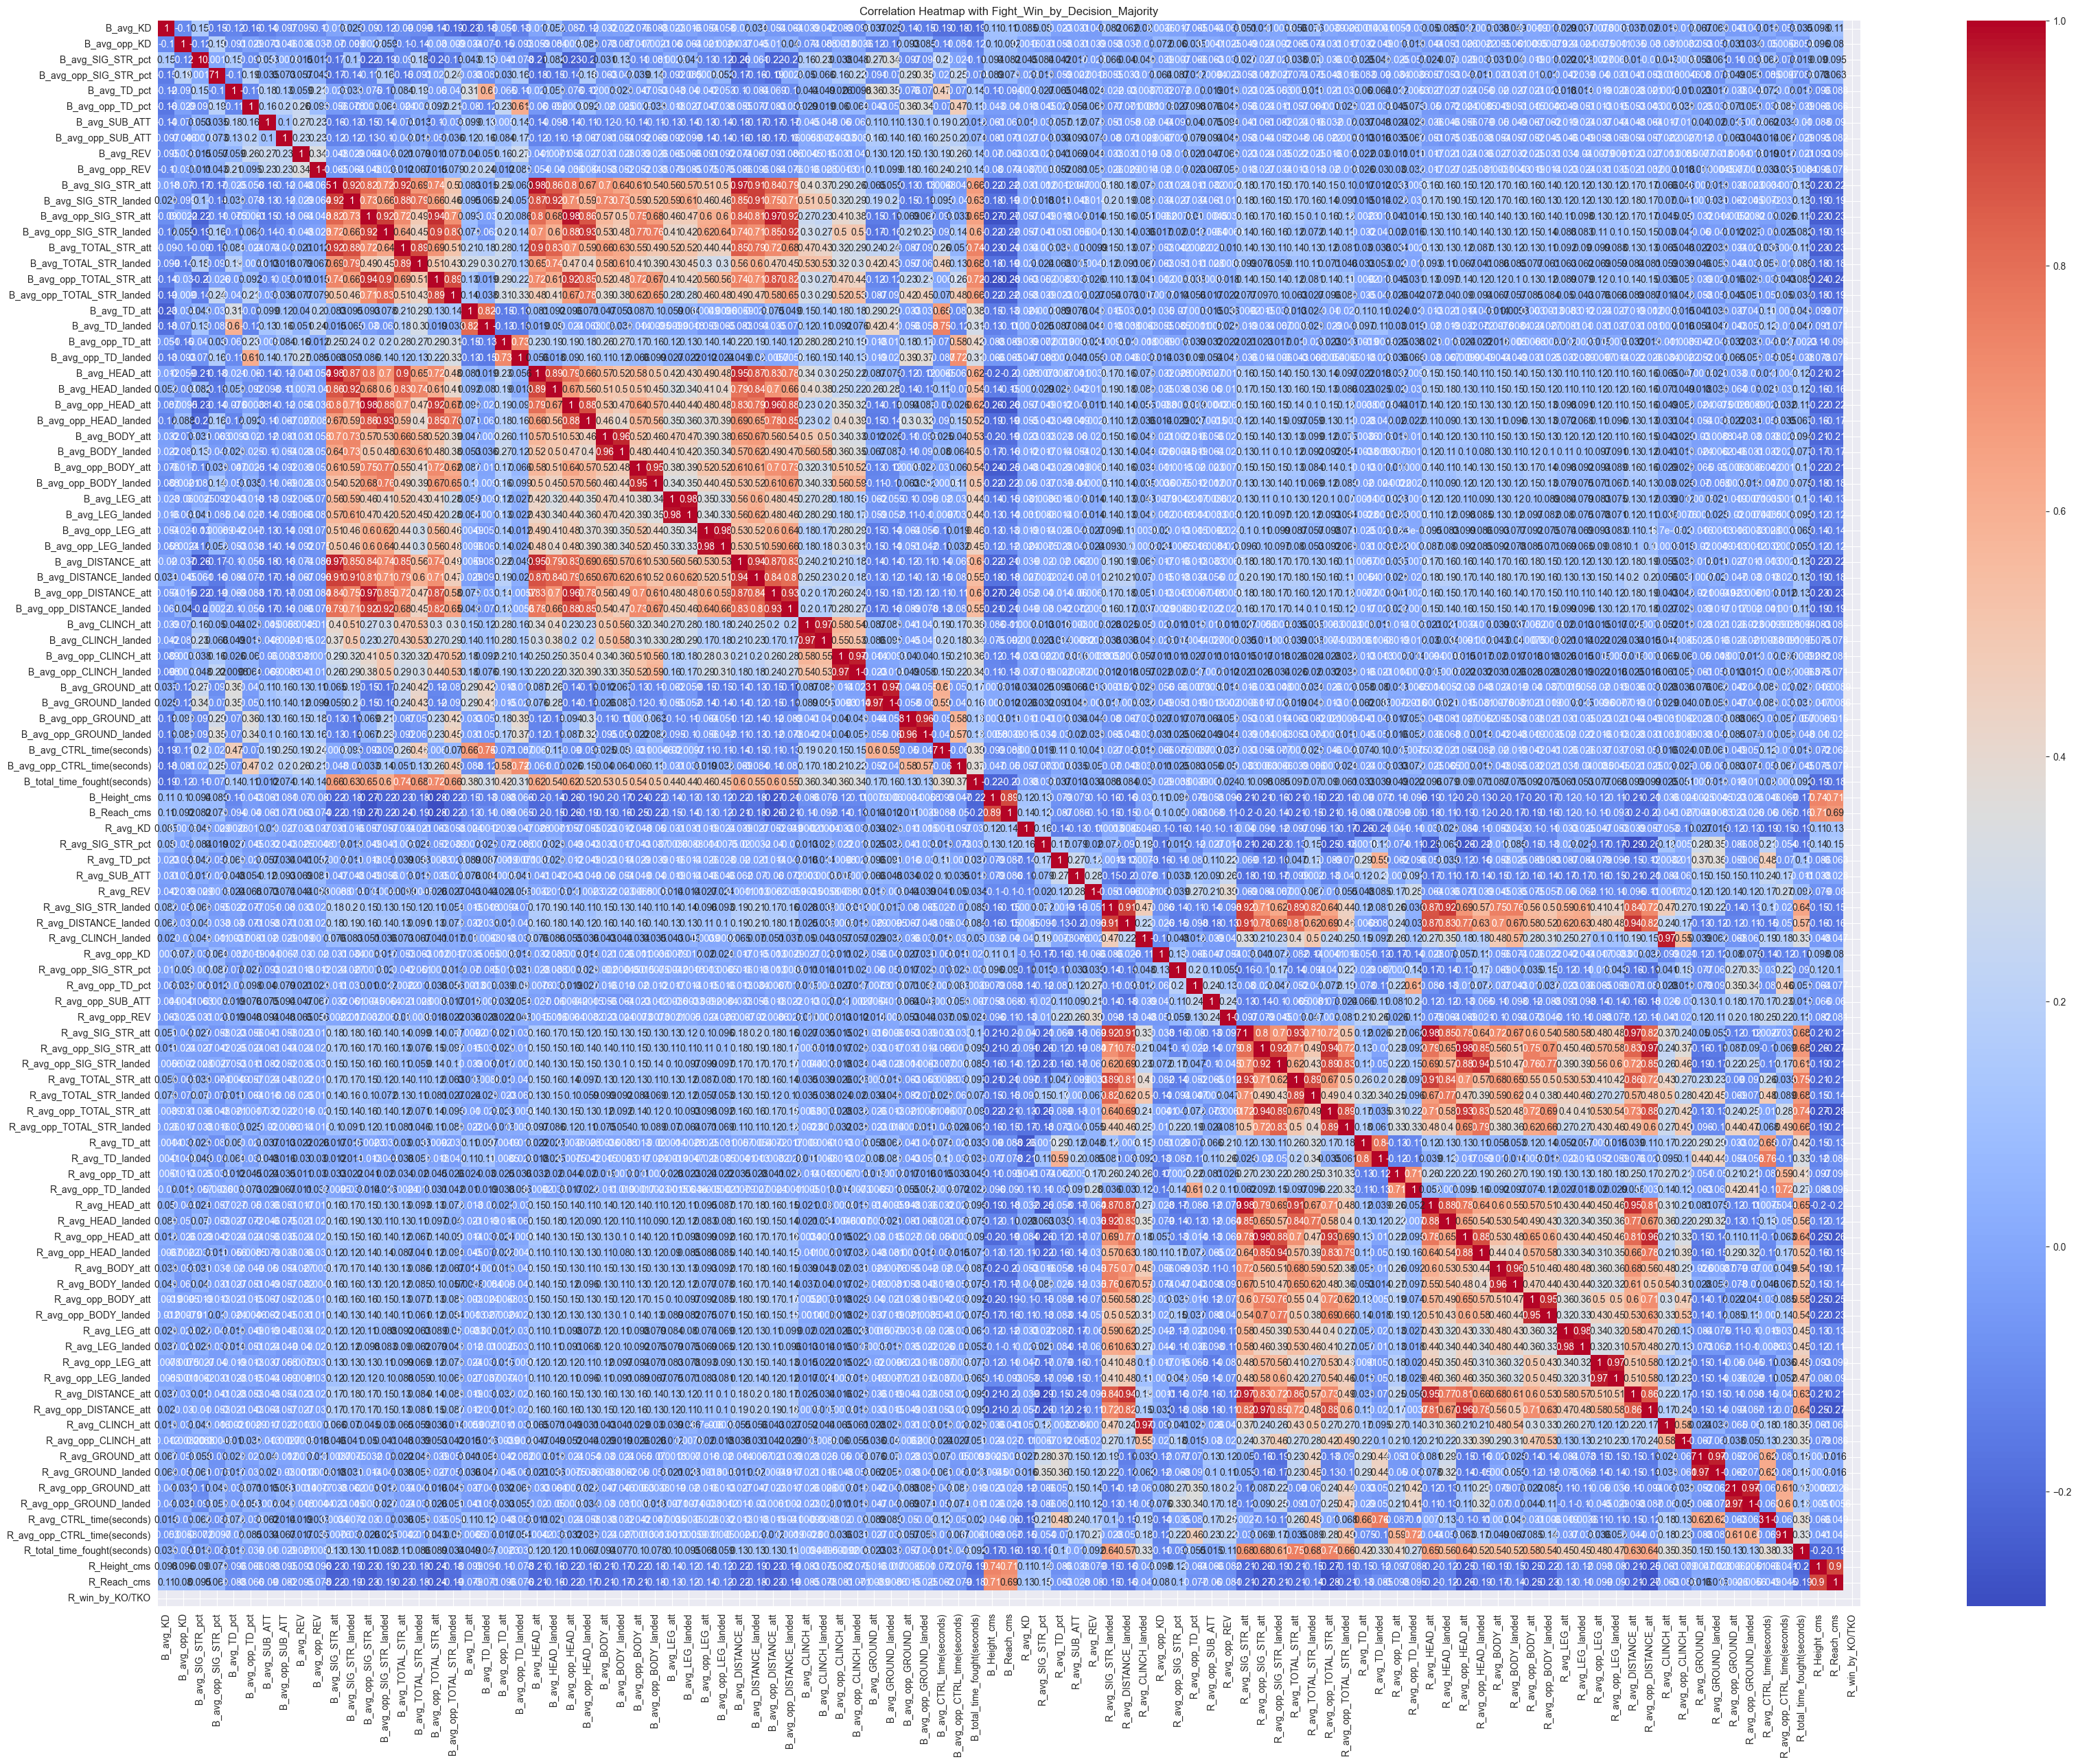

In [77]:
Combined_stats = [
    # Blue Corner Stats
    'B_avg_KD', 'B_avg_opp_KD', 'B_avg_SIG_STR_pct', 'B_avg_opp_SIG_STR_pct',
    'B_avg_TD_pct', 'B_avg_opp_TD_pct', 'B_avg_SUB_ATT', 'B_avg_opp_SUB_ATT',
    'B_avg_REV', 'B_avg_opp_REV', 'B_avg_SIG_STR_att', 'B_avg_SIG_STR_landed',
    'B_avg_opp_SIG_STR_att', 'B_avg_opp_SIG_STR_landed', 'B_avg_TOTAL_STR_att',
    'B_avg_TOTAL_STR_landed', 'B_avg_opp_TOTAL_STR_att', 'B_avg_opp_TOTAL_STR_landed',
    'B_avg_TD_att', 'B_avg_TD_landed', 'B_avg_opp_TD_att', 'B_avg_opp_TD_landed',
    'B_avg_HEAD_att', 'B_avg_HEAD_landed', 'B_avg_opp_HEAD_att', 'B_avg_opp_HEAD_landed',
    'B_avg_BODY_att', 'B_avg_BODY_landed', 'B_avg_opp_BODY_att', 'B_avg_opp_BODY_landed',
    'B_avg_LEG_att', 'B_avg_LEG_landed', 'B_avg_opp_LEG_att', 'B_avg_opp_LEG_landed',
    'B_avg_DISTANCE_att', 'B_avg_DISTANCE_landed', 'B_avg_opp_DISTANCE_att',
    'B_avg_opp_DISTANCE_landed', 'B_avg_CLINCH_att', 'B_avg_CLINCH_landed',
    'B_avg_opp_CLINCH_att', 'B_avg_opp_CLINCH_landed', 'B_avg_GROUND_att',
    'B_avg_GROUND_landed', 'B_avg_opp_GROUND_att', 'B_avg_opp_GROUND_landed',
    'B_avg_CTRL_time(seconds)', 'B_avg_opp_CTRL_time(seconds)', 'B_total_time_fought(seconds)',
    'B_Height_cms', 'B_Reach_cms',
    
# ]
# 
# R_stats = [
    # Red Corner Stats
    'R_avg_KD', 'R_avg_SIG_STR_pct', 'R_avg_TD_pct', 'R_avg_SUB_ATT', 'R_avg_REV',
    'R_avg_SIG_STR_landed', 'R_avg_DISTANCE_landed', 'R_avg_CLINCH_landed',
    'R_avg_opp_KD', 'R_avg_opp_SIG_STR_pct', 'R_avg_opp_TD_pct', 'R_avg_opp_SUB_ATT',
    'R_avg_opp_REV', 'R_avg_SIG_STR_att', 'R_avg_opp_SIG_STR_att', 'R_avg_opp_SIG_STR_landed',
    'R_avg_TOTAL_STR_att', 'R_avg_TOTAL_STR_landed', 'R_avg_opp_TOTAL_STR_att',
    'R_avg_opp_TOTAL_STR_landed', 'R_avg_TD_att', 'R_avg_TD_landed', 'R_avg_opp_TD_att',
    'R_avg_opp_TD_landed', 'R_avg_HEAD_att', 'R_avg_HEAD_landed', 'R_avg_opp_HEAD_att',
    'R_avg_opp_HEAD_landed', 'R_avg_BODY_att', 'R_avg_BODY_landed', 'R_avg_opp_BODY_att',
    'R_avg_opp_BODY_landed', 'R_avg_LEG_att', 'R_avg_LEG_landed', 'R_avg_opp_LEG_att',
    'R_avg_opp_LEG_landed', 'R_avg_DISTANCE_att', 'R_avg_opp_DISTANCE_att',
    'R_avg_CLINCH_att', 'R_avg_opp_CLINCH_att', 'R_avg_GROUND_att', 'R_avg_GROUND_landed',
    'R_avg_opp_GROUND_att', 'R_avg_opp_GROUND_landed', 'R_avg_CTRL_time(seconds)',
    'R_avg_opp_CTRL_time(seconds)', 'R_total_time_fought(seconds)',
    'R_Height_cms', 'R_Reach_cms',
]

sheet_data['R_win_by_KO/TKO'] = sheet_data.apply(
    lambda row: 1 if row['Winner'] == 'Decision - Majority' else 0, axis=1
)

analysis_data = sheet_data[Combined_stats + ['R_win_by_KO/TKO']]

analysis_data = analysis_data.dropna()

correlation_matrix = analysis_data.corr()

plt.figure(figsize=(40, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap with Fight_Win_by_Decision_Majority')
# plt.show()


## Modelling
The F1 Score is a metric used to evaluate a classification model. It combines precision and recall into a single metric.

In [81]:
from sklearn.metrics import f1_score
from sklearn.multioutput import MultiOutputClassifier

X = ufc_data[Combined_stats]
y = ufc_data[['Winner']]

X = X.fillna(0)
y = y.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Multilabel Classification Model
rf_model = RandomForestClassifier(random_state=42)
multi_output_model = MultiOutputClassifier(rf_model)

multi_output_model.fit(X_train, y_train)

y_pred = multi_output_model.predict(X_test)

for i, target in enumerate(y.columns):
    print(f"Evaluating {target}:")
    print("Accuracy:", accuracy_score(y_test[target], y_pred[:, i]))
    print("F1 Score:", f1_score(y_test[target], y_pred[:, i], average='weighted'))

# for i, target in enumerate(y.columns):
#     print(f"Feature Importance for {target}:")
#     feature_importances = pd.DataFrame({
#         'Feature': X_train.columns,
#         'Importance': multi_output_model.estimators_[i].feature_importances_
#     }).sort_values(by='Importance', ascending=False)
#     print(feature_importances)

Evaluating Winner:
Accuracy: 0.6791354945968412
F1 Score: 0.6237156938871218


## Random Forest Regressor
MSE needs to be a low number, this indicates that the model is performing well

R^2 needs to be close to one indicating better fit

If any R2R2 values are negative, it means the model performs worse than predicting the mean of the target variable

In [82]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

rf_regressor = RandomForestRegressor(random_state=42)

rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)

threshold = 0.1

scores = []
for i, col in enumerate(y.columns):

    r2 = r2_score(y_test[col], y_pred[:, i])
    
    mse = mean_squared_error(y_test[col], y_pred[:, i])
    
    correct_predictions = abs(y_pred[:, i] - y_test[col]) <= threshold
    accuracy = correct_predictions.sum() / len(y_test[col])
    
    scores.append({'Target': col, 'R2 Score': r2, 'MSE': mse, 'Accuracy': accuracy})
    print(f"Scores for {col}:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")

scores_df = pd.DataFrame(scores)

print(scores_df)


/Users/danilburov/Desktop/Fontys/Semester5/MinorAI/PythonCR/Personal project/.venv/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

## Gradient Boosting (XGBoost)

In [83]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Initialize placeholders for R² and MSE scores
r2_scores = []
mse_scores = []

# Train and evaluate a separate XGBRegressor for each target column
for col in y.columns:
    # Train a model for the current target
    xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
    xgb_model.fit(X_train, y_train[col])  # Train on the current target
    
    # Predict for the current target
    y_pred_xgb = xgb_model.predict(X_test)
    
    # Evaluate R² and MSE
    r2 = r2_score(y_test[col], y_pred_xgb)
    mse = mean_squared_error(y_test[col], y_pred_xgb)
    
    # Store scores
    r2_scores.append(r2)
    mse_scores.append(mse)
    
    # Print scores for the current target
    print(f"R² Score for {col} (XGBoost): {r2}")
    print(f"MSE for {col} (XGBoost): {mse}")


R² Score for Winner (XGBoost): -0.04274797439575195
MSE for Winner (XGBoost): 0.8903205294149108


## Support Vector Regressor

## Data visualization

In [84]:
accuracy_scores = [accuracy_score(y_test[col], y_pred[:, i]) for i, col in enumerate(y.columns)]

plt.bar(y.columns, accuracy_scores)
plt.title("Accuracy Scores for Each Target")
plt.ylabel("Accuracy Score")
plt.xlabel("Target")
plt.show()


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

## Probability prediction visualization

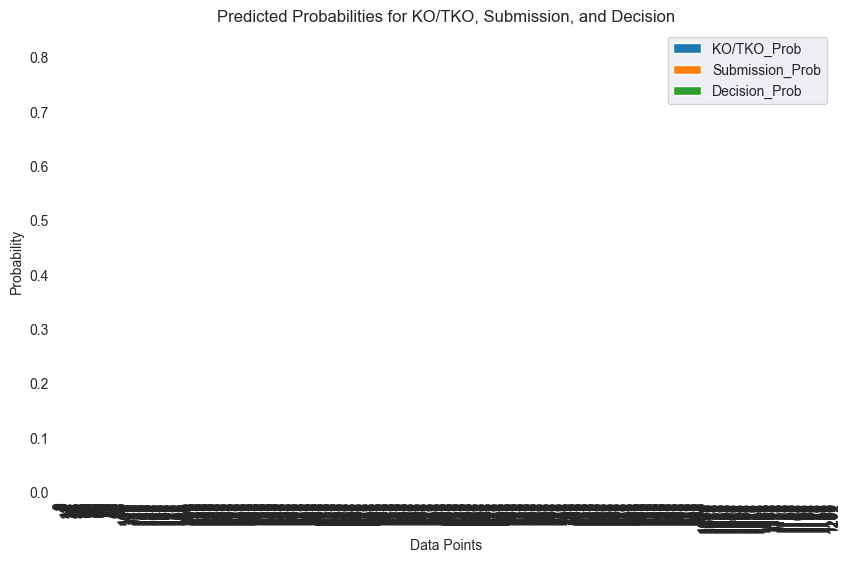

In [43]:
prob_df.plot(kind='bar', figsize=(10, 6))
plt.title("Predicted Probabilities for KO/TKO, Submission, and Decision")
plt.ylabel("Probability")
plt.xlabel("Data Points")
plt.legend(loc='upper right')
plt.show()


## Visualizing Feature Importances

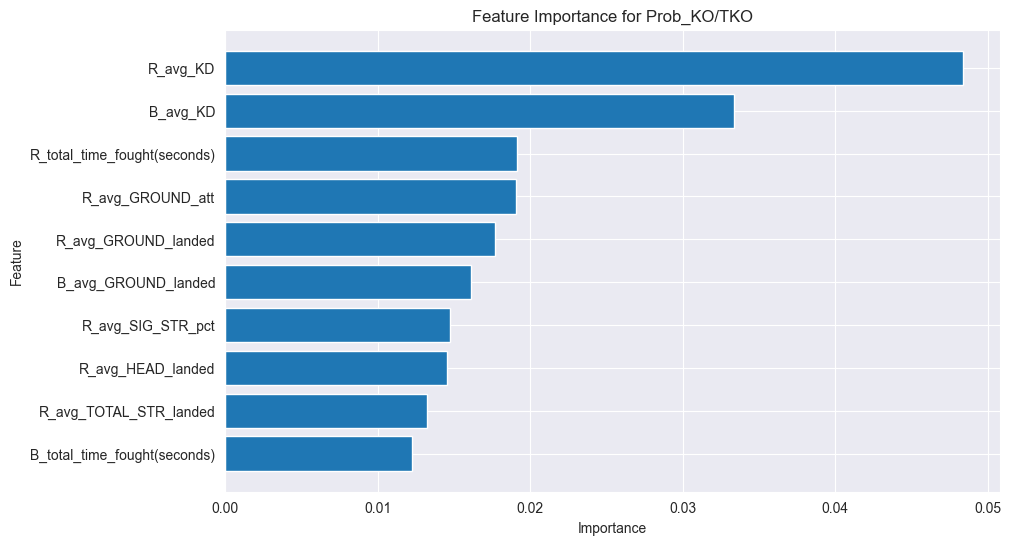

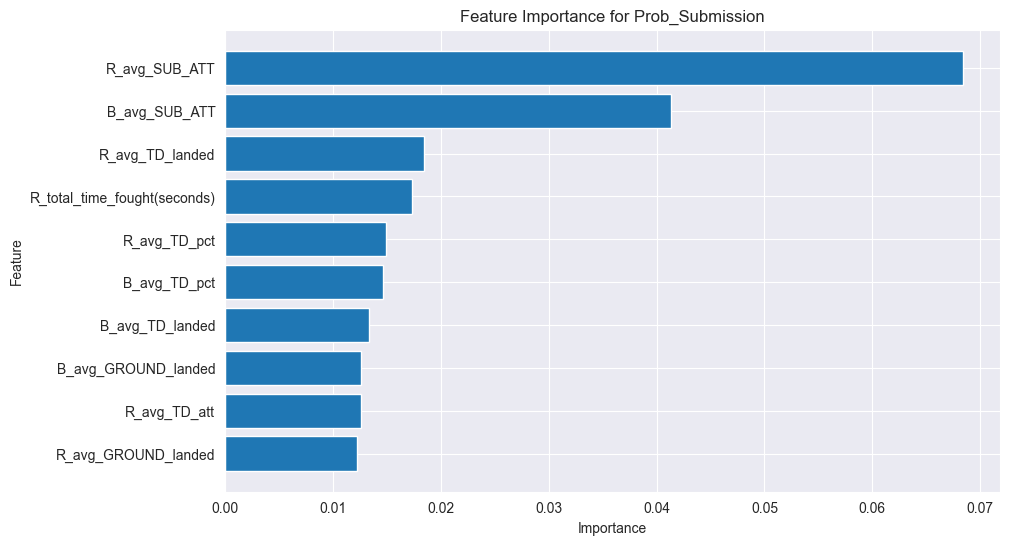

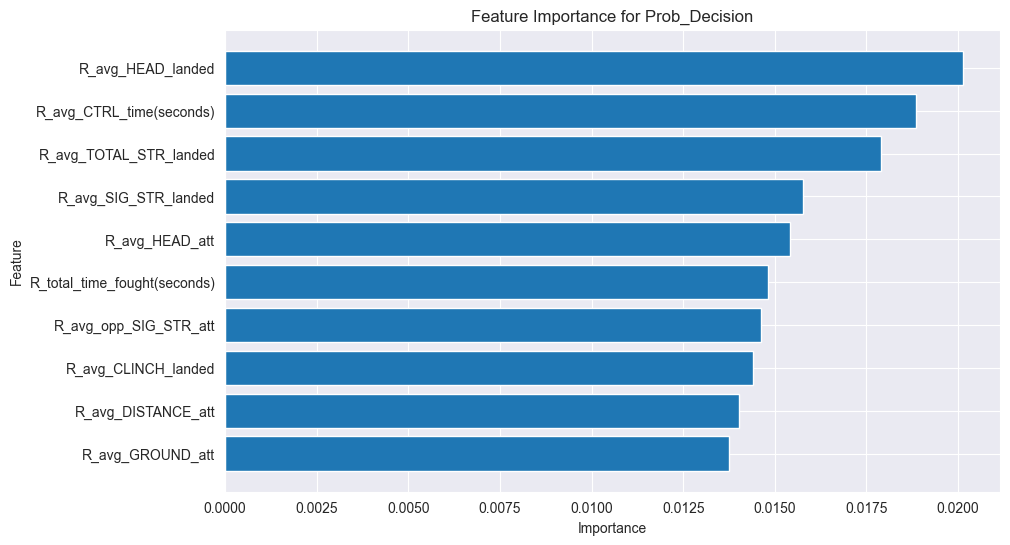

In [44]:
for i, target in enumerate(y.columns):
    feature_importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': multi_output_model.estimators_[i].feature_importances_
    }).sort_values(by='Importance', ascending=False)

    # Plot the top 10 important features
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importances['Feature'][:10], feature_importances['Importance'][:10])
    plt.title(f"Feature Importance for {target}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.show()


In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

missing_features = [col for col in R_stats if col not in ufc_data.columns]
if missing_features:
    print(f"Missing features: {missing_features}")
else:
    print("All features are present.")

X = ufc_data[R_stats]
y = ufc_data['R_win_by_KO/TKO']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)


All features are present.
                         Feature  Importance
0                       R_avg_KD    0.101469
46  R_total_time_fought(seconds)    0.053890
40              R_avg_GROUND_att    0.035468
41           R_avg_GROUND_landed    0.033566
25             R_avg_HEAD_landed    0.025902
1              R_avg_SIG_STR_pct    0.025658
3                  R_avg_SUB_ATT    0.025613
48                   R_Reach_cms    0.023529
11             R_avg_opp_SUB_ATT    0.021735
44      R_avg_CTRL_time(seconds)    0.020912
20                  R_avg_TD_att    0.019256
9          R_avg_opp_SIG_STR_pct    0.019211
21               R_avg_TD_landed    0.018079
5           R_avg_SIG_STR_landed    0.017966
42          R_avg_opp_GROUND_att    0.017714
7            R_avg_CLINCH_landed    0.017489
2                   R_avg_TD_pct    0.017394
19    R_avg_opp_TOTAL_STR_landed    0.017372
13             R_avg_SIG_STR_att    0.017353
45  R_avg_opp_CTRL_time(seconds)    0.017328
38              R_avg_CLINCH_